<a href="https://colab.research.google.com/github/afr0thunder/brain_tumors/blob/main/brain_tumor_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tuning Multi-class Brain Tumor Classification Using MRI BRain Scan Images

The goal of this notebook is to try efficiently model and tune using several training models with the eventual goal of comparing accuracy and losss. The beginning of the notebook imports the brain tumor data and preapres it for testing, the final part of the notebook tunes, optimizes and creates the models.


## IMPORTANT

Below are some gloabal parameters, including the link for the training model:

In [38]:
# Quantity of images to proess and batch, total # of images in the dataset is 3096
NUM_IMAGES = 3096

# Define image resolution for processing (original size of dataset is 256x256)
IMG_SIZE = 331

# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Define the # of Epoch
EPOCHS = 50

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/nasnet_large/classification/5'

# Prepare Workspace

In [39]:
# Import necessary tools
!pip install keras_tuner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
import datetime
import os
import tensorflow as tf
import keras_tuner as kt
from keras_tuner import HyperModel
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
import tensorflow_hub as hub
print ("TF version: ", tf.__version__)
print ("TF Hub version: ", hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version:  2.13.0
TF Hub version:  0.15.0
GPU available


# Prepare the data for analysis

The data needs the following:
* A csv file needs to be prepared with pathnames for each image and containing the classifiaction for each image

In [40]:
# Create an array with file names for images and an array with label classifications
filenames = []
labels = []

for image in range(0, len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/'))):
    filenames.append(f'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_{image+1}.jpg')
    labels.append('glioma_tumor')
for image in range(0, len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/'))):
    filenames.append(f'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/M_{image+1}.jpg')
    labels.append('meningioma_tumor')
for image in range(0, len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/'))):
    filenames.append(f'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/N_{image+1}.jpg')
    labels.append('normal')
for image in range(0, len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/'))):
    filenames.append(f'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/P_{image+1}.jpg')
    labels.append('pituitary_tumor')

In [41]:
# Check the first 10
filenames[:10]

['drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_1.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_2.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_3.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_4.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_5.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_6.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_7.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_8.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_9.jpg',
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_10.jpg']

In [42]:
# Check the first 10
labels[:10]

['glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor']

In [43]:
# Check whether number of filenames matches number of actual image files
directory_length = len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/')) + len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/')) + len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/')) + len(os.listdir('drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/'))

if directory_length == len(filenames):
  print("Filenames length matches # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of filenames: {len(filenames)}')
else:
  print("Filenames length does not match # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of filenames: {len(filenames)}')

# Check whether number of labels matches number of actual image files
if directory_length == len(filenames):
  print("Labels length matches # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of labels: {len(labels)}')
else:
  print("Labels length does not match # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of labels: {len(labels)}')

Filenames length matches # of images
# of images: 3096
Length of filenames: 3096
Labels length matches # of images
# of images: 3096
Length of labels: 3096


In [44]:
# Find the unique label values
diagnosis = np.unique(labels)
len(diagnosis)

4

In [45]:
# Turn every label into a boolean array
boolean_labels = [label == diagnosis for label in labels]
boolean_labels[:3]

[array([ True, False, False, False]),
 array([ True, False, False, False]),
 array([ True, False, False, False])]

In [46]:
# Check if boolean_labels is the same length as # of images
if directory_length == len(boolean_labels):
  print("Boolean_labels length matches # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of boolean_labels: {len(boolean_labels)}')
else:
  print("Boolean_labels length does not match # of images")
  print(f'# of images: {directory_length}')
  print(f'Length of boolean_labels: {len(boolean_labels)}')

Boolean_labels length matches # of images
# of images: 3096
Length of boolean_labels: 3096


In [47]:
# Create dataframe with both arrays
np.random.seed(42)
filenames_np = np.array(filenames)
boolean_labels_np = np.array(boolean_labels)

# shuffle arrays in unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

filenames_np_shuffled, boolean_labels_np_shuffled = unison_shuffled_copies(filenames_np, boolean_labels_np)

print(filenames_np_shuffled[:10])
print(boolean_labels_np_shuffled[:10])

['drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/N_134.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/M_409.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/M_706.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/P_375.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/P_189.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/normal/N_144.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/pituitary_tumor/P_472.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_185.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/meningioma_tumor/M_360.jpg'
 'drive/MyDrive/Google Colab/Data Sets/brain_tumors/Data/glioma_tumor/G_195.jpg']
[[False False  True False]
 [False  True False False]
 [False  True False False]
 [False False False  True]
 [False False False  True]
 [False False  True False]
 [False False Fals

## Create train, validation, and test sets

In [48]:
# Setup X & y variables
X = filenames_np_shuffled
y = boolean_labels_np_shuffled

In [49]:
# Split data into train and test/validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X[:NUM_IMAGES],
                                                   y[:NUM_IMAGES],
                                                   test_size=0.3,
                                                   random_state=42)

len(X_train), len(y_train), len(X_test_val), len(y_test_val)

(2167, 2167, 929, 929)

In [50]:
# Split test_val into test and validation sets
split = int(round(len(X_test_val)/2))

X_val = X_test_val[:split]
X_test = X_test_val[split:]
y_val = y_test_val[:split]
y_test = y_test_val[split:]

len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(2167, 2167, 464, 464, 465, 465)

## Preprocessing Images (turning images into Tensors)

Going to write a function that:

* Take an image filepath as input
* Use TensorFlow to read the file and save it to a variable image
* Convert color values from 0-255 to 0-1 at the same scale
* Turn our image (a jpg) into Tensors
* Resize the image to be a shape of (256, 256)
* Return the modified image

In [51]:
# Create function to preprocess data
def process_image(image_path):
  """
  Takes an image file path and turn the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerial Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to desired value
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches (32 is standard size)

batch size adjusts for memory available

data needs to be in the form of Tensor tuples which look like this: `(image, label)`

In [52]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

## Create a function that batches the data for processing

In [53]:
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs. Shuffles, the data if it's training data, but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels.)
  """
  # If the data is a test dataset, will not have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths(no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a validation dataset, will not need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # Create training batches
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor is faster than shuffling later
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turn the image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [54]:
# Create training and validation data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
test_data = create_data_batches(X_test, y_test, valid_data=True)

Creating training data batches...
Creating validation data batches...
Creating validation data batches...


In [55]:
# Check out the different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 331, 331, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 331, 331, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Need to visualize the data as it is difficult to understand

In [56]:
# Create a function for viewing images in a data batch
def show_25_images(image, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  #loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 row, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(image[i])
    # Add the image label as the title
    plt.title(diagnosis[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [57]:
train_images, train_labels = next(train_data.as_numpy_iterator())

len(train_images), len(train_labels)

(32, 32)

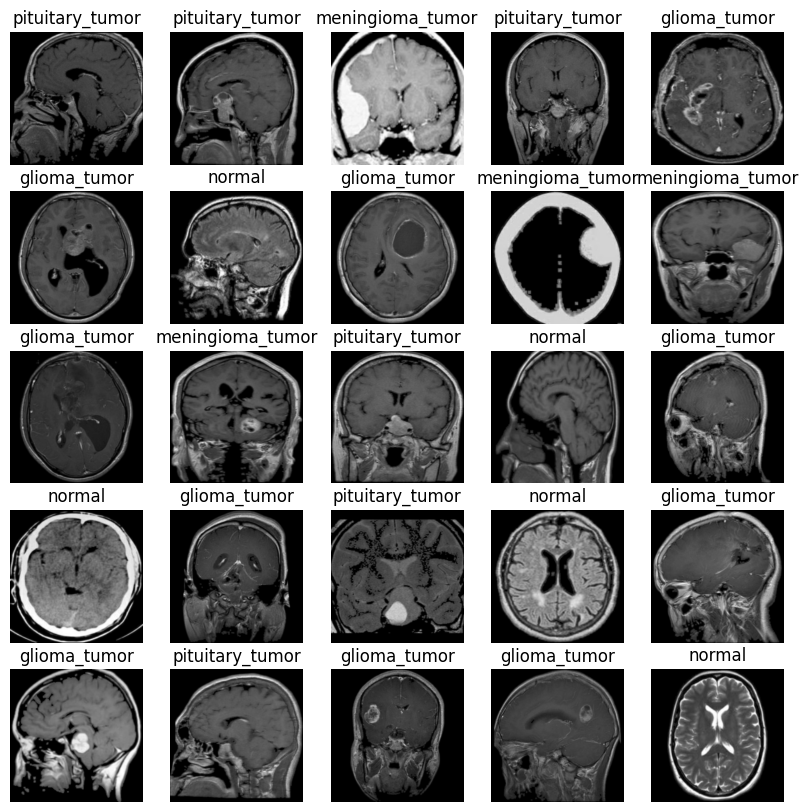

In [58]:
# Visualize the data in a training batch
show_25_images(train_images, train_labels)

## Building a model

Before a model is built, a few things need to be defined:

* The input shape (image shape, in the form of Tensors) to the model.
* The output shape (image labels, in the form of Tensors) of the model.
* The URL of the model we want to use

In [59]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of the model
OUTPUT_SHAPE = len(diagnosis)

Now there are inputs, outputs and model ready to go, combine them together into a Kera deep learning model.

Need to create a function which:
* Takes the input shape, outputs shape and the model chosen as paramters.
* Defines the layers in a Keras model in sequential fashion (do this first, then that)
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

In [60]:
# Use a model class to generate a model
class MyHyperModel(HyperModel):
    def __init__(self, model_url, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.model_url = model_url

    def build(self, hp):
        model = tf.keras.Sequential([
            hub.KerasLayer(self.model_url),  # Layer 1 (input layer)
            tf.keras.layers.Dense(
                # Tune the number of units in the Dense layer
                # Choose an optimal value between 32-512
                units=hp.Int('units', min_value=32, max_value=512, step=32),
                activation='relu'  # Or another activation function
            ),  # Layer 2
            tf.keras.layers.Dense(self.output_shape, activation='softmax')  # Layer 3 (output layer)
        ])

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            metrics=['accuracy']
        )

        return model

## Creating Callbacks

Callbacks are helper functions a model can use during the training to do such things as save its progress, check its progress or stop training early if a model stops improving

Need to create two callbacks, one for TensorBoard which helps track the models progress and another for early stopping which prevents the model from training for too long.

TensorBoard Callback
To setup a TensorBoard callback, will need to do 3 things:
1. Load the TensorBoard notebook extenstion
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to the model's `fit()` funtion
3. Visualize the models training logs with the `%tensorboard` magic function (we'll do this after model training)

In [61]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [62]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Google Colab/Data Sets/brain_tumors/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [63]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=5)

## Training the first model

In [64]:
nasnet_large__classification = MyHyperModel(MODEL_URL, INPUT_SHAPE, OUTPUT_SHAPE)

In [65]:
# Create tuner for tuning the model
tuner = RandomSearch(
    nasnet_large__classification,
    objective='accuracy',
    max_trials=5,  # the number of different hyperparameter combinations to try
    executions_per_trial=3,  # the number of models to build for each trial for robustness
    directory='drive/MyDrive/Google Colab/Data Sets/brain_tumors/tuners/random_search/',
    project_name='nasnaet_large'
)

In [ ]:
tuner.search(train_data, epochs=EPOCHS, callbacks=[early_stopping], verbose = 1)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
320               |320               |units
0.0001            |0.0001            |learning_rate

Epoch 1/50
68/68 [==============================] - 291s 4s/step - loss: 0.9761 - accuracy: 0.5907
Epoch 2/50
68/68 [==============================] - 70s 1s/step - loss: 0.6194 - accuracy: 0.7656
Epoch 3/50
68/68 [==============================] - 69s 1s/step - loss: 0.5248 - accuracy: 0.7970
Epoch 4/50
68/68 [==============================] - 69s 1s/step - loss: 0.4631 - accuracy: 0.8297
Epoch 5/50
68/68 [==============================] - 70s 1s/step - loss: 0.4185 - accuracy: 0.8537
Epoch 6/50
68/68 [==============================] - 70s 1s/step - loss: 0.3891 - accuracy: 0.8671
Epoch 7/50
68/68 [==============================] - 69s 1s/step - loss: 0.3576 - accuracy: 0.8814
Epoch 8/50
68/68 [==============================] - 69s 1s/step - loss: 0.3318 - accuracy: 0.8976
Epoch 9/50
68/68 [====================

In [ ]:
# Rebuild the model with the best hyperparameters
nasnet_large__classification_tuned = tuner.hypermodel.build(best_hps)

# Retrain the model
history = nasnet_large__classification_tuned.fit(
    train_data,  # Note: use your entire training data here
    epochs=EPOCHS,  # Or another value
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
# Note: Ensure your test data is preprocessed in the same way as your training data
test_loss, test_accuracy = nasnet_large__classification_tuned.evaluate(test_data)

print(f"\n\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## SAVE AND LOAD MODEL

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Google Colab/Data Sets/brain_tumors/models/",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model
save_model(nasnet_large__classification_tuned, suffix=('nasnet_large__classification'))

In [ ]:
# Load a trained model
loaded_model = load_model('/content/drive/MyDrive/Google Colab/Data Sets/brain_tumors/models/20231015-18261697394408-nasnet_large__classification_tuned.h5')

In [ ]:
loaded_model.evaluate(val_data)